In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt


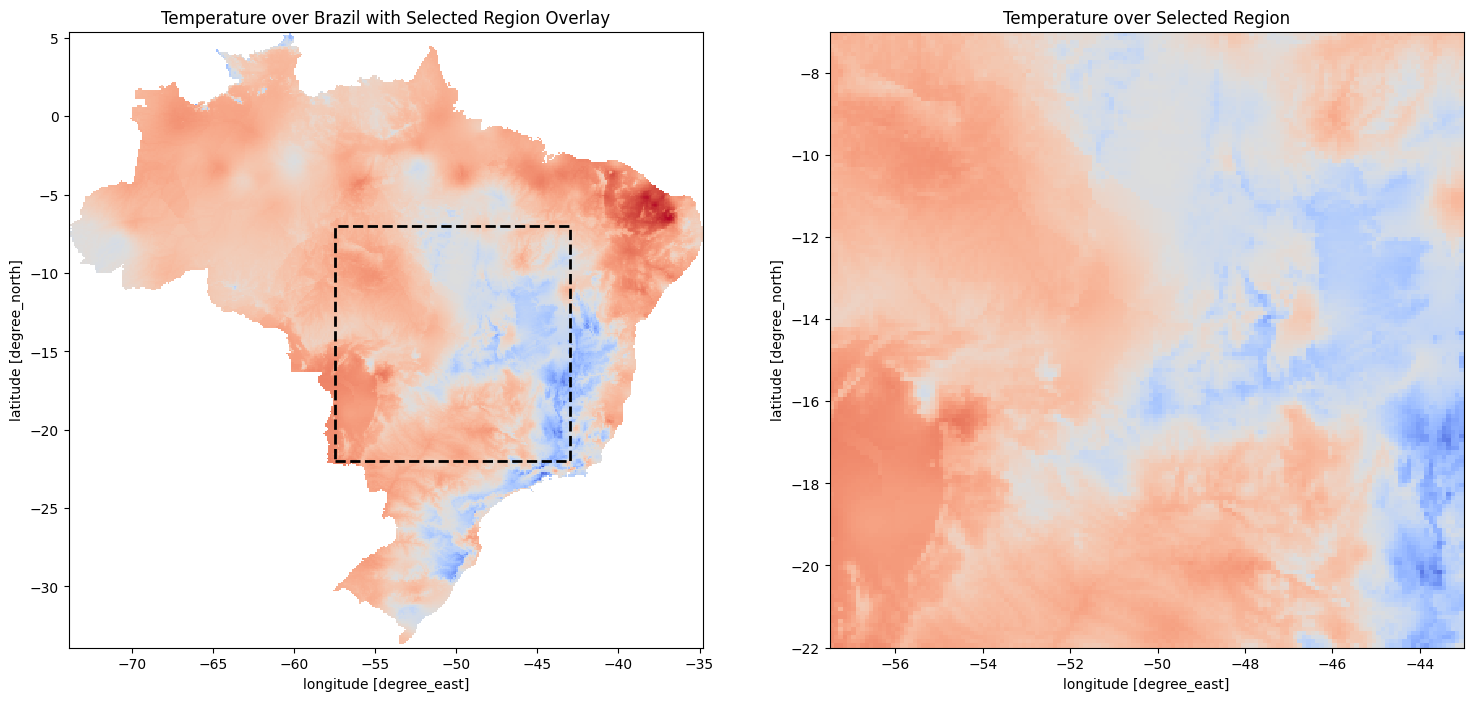

In [6]:
file_path = f"../data/raw/Tmax_20010101_20240320_BR-DWGD_UFES_UTEXAS_v_3.2.3.nc"
cur_df = xr.open_dataset(file_path, engine="netcdf4")

lat_min, lat_max = -22.0, -7.0
lon_min, lon_max = -57.5, -43.0
cropped = cur_df.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Background: Full Brazil
cur_df.Tmax.isel(time=0).plot(ax=axs[0], cmap='coolwarm', add_colorbar=False)
cropped.Tmax.isel(time=0).plot(ax=axs[1], cmap='coolwarm', add_colorbar=False,vmin=cur_df.Tmax.isel(time=0).min(), vmax=cur_df.Tmax.isel(time=0).max())

# Overlay: São Paulo (as contour or colormap)

# Optional: Draw bounding box
axs[0].plot([lon_min, lon_max, lon_max, lon_min, lon_min],
        [lat_min, lat_min, lat_max, lat_max, lat_min],
        color='black', linewidth=2, linestyle='--', label='Selected Region')

# Final touches
axs[0].set_title("Temperature over Brazil with Selected Region Overlay")
axs[1].set_title("Temperature over Selected Region")

plt.show()

In [22]:
import sys

if '..' not in sys.path:
    sys.path.insert(0, '..')
from src.data.load_variables import load_brasil_surf_var, load_era5_static_variables

surf_vars_values, time, mask = load_brasil_surf_var(['Tmin'],lat_lim= [-22.0, -7.0],lon_lim=[-57.5, -43.0],n_samples=10) # ['Tmax','Tmin','pr']
# static_vars_values, lat, lon  = load_era5_static_variables(['slt'],mask=mask,lat_lim= [-22.0, -7.0],lon_lim= [-57.5, -43.0]) #['slt','geo']


In [91]:
import torch

area=[5.3, -73.9, -33.9, -34.9]
var='geo'
file_path = f"data/raw/{var}.area-subset.{area[0]}.{area[3]}.{area[2]}.{area[1]}.nc"
cur_var = xr.open_dataset(file_path, engine="netcdf4")
var_name = next(iter(cur_var.variables))

lat_lim= [-22.0, -7.0]
lon_lim=[-57.5, -43.0]


lat = cur_var.latitude
lon = cur_var.longitude

# --- Fix longitude range if dataset is 0–360 ---
if lon.min() >= 0:  # means it's [0, 360]
    lon_lim = [(x + 360) if x < 0 else x for x in lon_lim]

# --- Select latitude safely ---
if lat[0] > lat[-1]:  # descending
    lat_slice = slice(lat_lim[1], lat_lim[0])
else:
    lat_slice = slice(lat_lim[0], lat_lim[1])

# --- Select longitude safely ---
if lon[0] > lon[-1]:  # descending
    lon_slice = slice(lon_lim[1], lon_lim[0])
else:
    lon_slice = slice(lon_lim[0], lon_lim[1])

# --- Apply selection ---
cur_var = cur_var.sel(latitude=lat_slice, longitude=lon_slice)
    
cur_var =torch.from_numpy(cur_var[var_name][0].values)

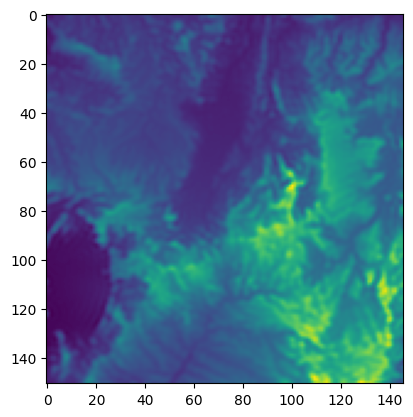

In [95]:
plt.imshow(cur_var)

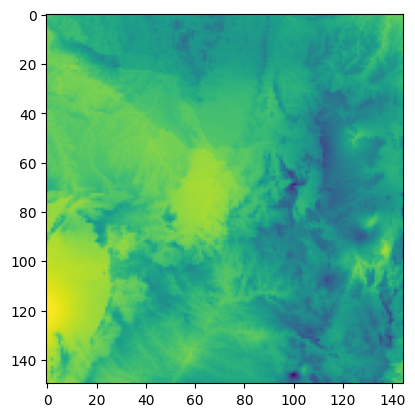

In [96]:
plt.imshow(surf_vars_values['Tmin'][0])

In [40]:
cur_var

tensor([], size=(0, 0), dtype=torch.float64)

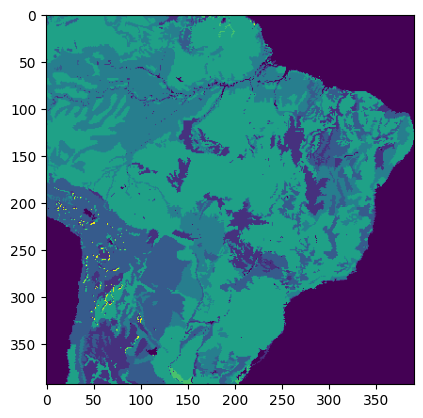

In [5]:
file_path = f"../data/raw/slt.area-subset.5.3.-34.9.-33.9.-73.9.nc"

cur_df = xr.open_dataset(file_path, engine="netcdf4")
plt.imshow(cur_df.slt.isel(time=0))

In [ ]:
plt.hist(cropped.Tmax.values.flatten(), bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Histogram of Tmax values (cropped region)')
plt.show()

In [ ]:
new_vals = (cropped.Tmax.values - np.nanmean(cropped.Tmax.values))/np.nanstd(cropped.Tmax.values)

In [ ]:
np.nanmin(new_vals), np.nanmax(new_vals)

(-7.46921396917096, 3.927038870478597)

In [ ]:
np.nanmean(new_vals), np.nanstd(new_vals)

(2.2873306959425036e-14, 0.9999999999999982)

In [ ]:
new_vals.shape

(8480, 150, 145)

In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt


In [2]:
import os, sys
if '..' not in sys.path:
    sys.path.append('..')
    os.chdir('..')
    
from src.data_manager import BrazilWeatherDataset, transforms

dataset = BrazilWeatherDataset( transform=None,
                                surf_vars=['pr'],
                                static_vars=None,
                                lat_lim=[-22.0, -7.0], lon_lim=[-57.5, -43.0])

Removing most precipitation samples with average < 5mm


In [3]:
dataset.imgs.mean(dim=(0,2,3)), dataset.imgs.std(dim=(0,2,3))

(tensor([7.8689]), tensor([9.9052]))

In [4]:
dataset.imgs.amin(dim=(0,2,3)), dataset.imgs.amax(dim=(0,2,3))

(tensor([0.]), tensor([231.1594]))

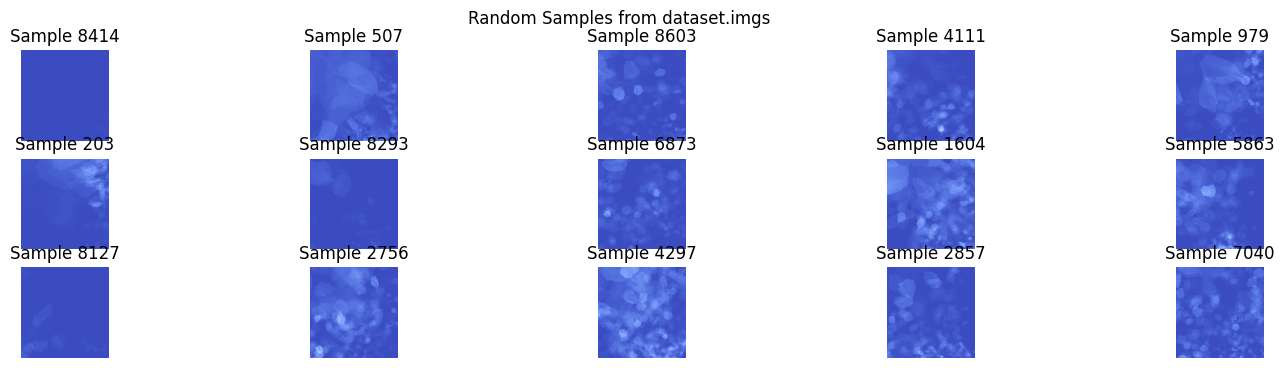

In [5]:
num_samples = 15
vmin=dataset.imgs.amin().item()
vmax=dataset.imgs.amax().item()

fig, axs = plt.subplots(num_samples//5, 5, figsize=(18, 4))

for idx, i in enumerate(axs.flatten()):

    idx = np.random.randint(0, dataset.imgs.shape[0])   
    img = dataset.imgs[idx].numpy()
    if img.shape[0] == 1:
        i.imshow(img[0], cmap='coolwarm',vmin=vmin, vmax=vmax)
    i.set_title(f"Sample {idx}")
    i.axis('off')
plt.suptitle("Random Samples from dataset.imgs")
plt.show()

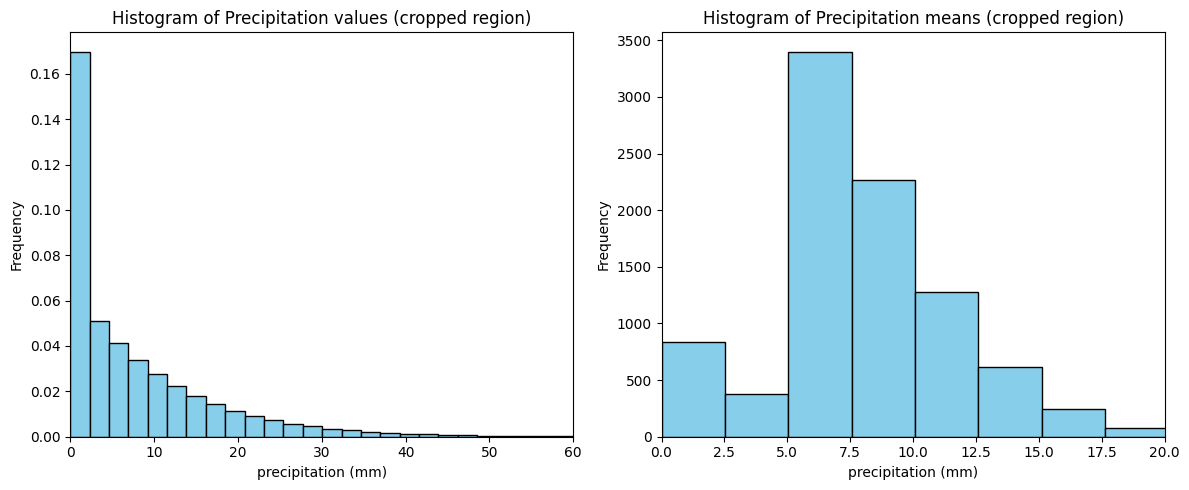

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(dataset.imgs.flatten(), bins=100, color='skyblue', edgecolor='black', density=True)
axs[0].set_xlabel('precipitation (mm)')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0, 60)
axs[0].set_title('Histogram of Precipitation values (cropped region)')

axs[1].hist(dataset.imgs.mean(axis=(1,2,3)).flatten(), bins=10, color='skyblue', edgecolor='black')
axs[1].set_xlabel('precipitation (mm)')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(0, 20)
axs[1].set_title('Histogram of Precipitation means (cropped region)')

plt.tight_layout()
plt.show()

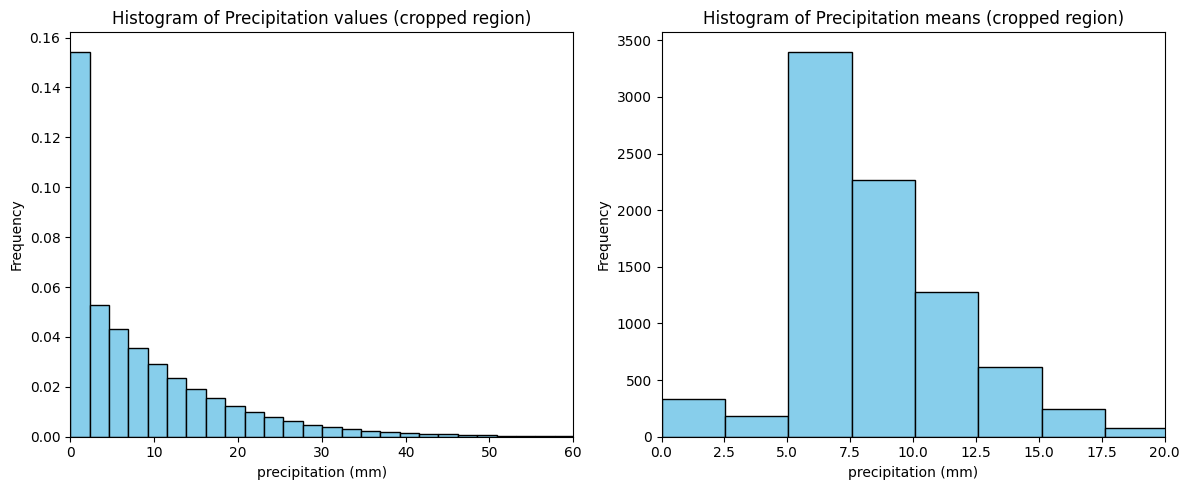

In [7]:
total_percnt = 0.05
val_crop = 5
low_prep_samples = dataset.imgs[dataset.imgs.mean(dim=(1,2,3)) < val_crop]
other_samples = dataset.imgs[dataset.imgs.mean(dim=(1,2,3)) >= val_crop]

n_samples = int((total_percnt*dataset.imgs.shape[0]) // 1)
samples = np.linspace(0, low_prep_samples.shape[0] - 1, n_samples, dtype=int)

new_dataset = np.concatenate((other_samples,low_prep_samples[samples]))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(new_dataset.flatten(), bins=100, color='skyblue', edgecolor='black', density=True)
axs[0].set_xlabel('precipitation (mm)')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0, 60)
axs[0].set_title('Histogram of Precipitation values (cropped region)')

axs[1].hist(new_dataset.mean(axis=(1,2,3)).flatten(), bins=10, color='skyblue', edgecolor='black')
axs[1].set_xlabel('precipitation (mm)')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(0, 20)
axs[1].set_title('Histogram of Precipitation means (cropped region)')

plt.tight_layout()
plt.show()

In [9]:
# rand_transform = transforms.Compose([
#         transforms.RandomResizedCrop(128, scale=(0.5, 1.0)),
#         transforms.Normalize(
#             (18.9116, 31.1490), #'Tmin', 'Tmax',
#             (3.2707, 3.2754))
#     ])

# t_dataset = rand_transform(dataset.imgs)
# t_dataset.amin(dim=(0,2,3)), t_dataset.amax(dim=(0,2,3))